In [1]:
import gzip
import json
import pickle
import os
from loguru import logger

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
import geopandas as gpd

import numpy as np
import pandas as pd

from ppgmne_prf.config.paths import PATH_DATA_SOLVER_DETAILS, PATH_DATA_SOLVER_RESULTS, PATH_DATA_IBGE_UF, PATH_DATA_CACHE
from ppgmne_prf.utils import get_distance_matrix
from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess_accidents, preprocess, preprocess_stations
from ppgmne_prf.utils import clean_string

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [15, 8]

sns.set_palette('deep')
PALETTE = sns.color_palette()

MAP_COLOR = '#d1cab2'
SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')

In [2]:
# Funções úteis:

def get_df_results(df_results, p=None, q=None):
    if p is None:
        df_out = df_results[(df_results['q'] == q)].copy()
    if q is None:
        df_out = df_results[(df_results['p'] == p)].copy()
    df_out['obj_function_abs_diff'] = abs(df_out['obj_function'].diff().fillna(0))
    df_out['obj_function_abs_pct_change'] = abs(df_out['obj_function'].pct_change().fillna(0))*100
    df_out['obj_function_abs_pct_change'] = np.where(
        df_out['obj_function_abs_pct_change'] == 0, 
        np.nan, 
        df_out['obj_function_abs_pct_change']
    )
    return df_out

def get_solution_details(q, p):
    model_name = f'model_p{p}_q{q}_details'
    with gzip.open(PATH_DATA_SOLVER_DETAILS / f"{model_name}.gz", "rb") as f:
            df_out = pickle.load(f)
    return df_out


def preproccess_muns(df_muns):
    cols = ['municipio', 'microrregiao', 'mesorregiao', 'regiao_imediata']
    cols_en = ['municipality', 'microregion', 'mesoregion', 'immediate_region', 'mun_name_orig']
    df_out = df_muns[cols].copy()
    df_out['mun_name_orig'] = df_out['municipio']

    for col in cols:
        df_out = clean_string(df=df_out, target=col, mode='upper')

    df_out.columns = cols_en
    return df_out


def get_all_results():
    output_dict = None

    for file in os.listdir(PATH_DATA_SOLVER_RESULTS):
        if file.split(".")[-1] == "json":
            with open(PATH_DATA_SOLVER_RESULTS / file) as file:
                dict_result = json.load(file)
            if output_dict is None:
                output_dict = dict_result
                for key in dict_result:
                    output_dict[key] = [dict_result[key]]
            else:
                for key in dict_result:
                    output_dict[key].append(dict_result[key])

    df_out = pd.DataFrame(output_dict)
    df_out = df_out.sort_values(['p', 'q']).reset_index(drop=True)
    return df_out


def plot_fo(
    df_plot,
    x_param,
    xtick_min=0,
    xtick_max=80,
    xtick_multiple=2,
    p2_ytick_max=15,
    pct_cutover=2.5,
    x_cutover=None,
    xlabel='Número de UOPs a serem instaladas (p)',
    p1_ylabel='Função Objetivo (Z)',
    p2_ylabel='Decrescimento Percentual de Z',
    fontsize=14,
    figsize=(15,8),
    invert_x=False,
    palette=PALETTE,
    arrow_txt="p = 36",
    arrow_xy=(35.7, 2.25),
    arrow_txt_xy=(20, 1),
    only_feasible=False):

    if only_feasible:
        df_plot = df_plot[df_plot['is_feasible'] == True]

    plt.subplots(figsize=figsize)

    p1 = sns.lineplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    sns.scatterplot(df_plot, x=x_param, y='obj_function', color=palette[0])
    p1.set_xlabel(xlabel,fontsize=fontsize)
    p1.set_ylabel(p1_ylabel, color=palette[0], fontsize=fontsize)

    p2 = p1.twinx()
    sns.lineplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    sns.scatterplot(df_plot, x=x_param, y='obj_function_abs_pct_change', color=palette[1])
    p2.set_yticks(range(0, p2_ytick_max+1, 1))
    p2.set_ylabel(p2_ylabel, color=palette[1], fontsize=fontsize)

    if pct_cutover is not None:
        plt.axhline(y=pct_cutover, color=palette[7], linestyle='--')

    if x_cutover is not None:
        plt.axvline(x=x_cutover, color=palette[7], linestyle='--')

    if invert_x:
        plt.gca().invert_xaxis()

    if arrow_txt is not None:
        plt.annotate(arrow_txt, xy=arrow_xy, xytext=arrow_txt_xy, arrowprops={'arrowstyle': "->"})

    plt.xticks(range(xtick_min, xtick_max+1, xtick_multiple))
    plt.savefig('foo.png')   
    plt.show()


def get_uops_by_sol(df_feasibles):
    dict_sols = {'p': [], 'q': [], 'name': []}

    for row in df_feasibles.itertuples():
        df_sol = get_solution_details(p=row.p, q=row.q)
        uops = list(df_sol[df_sol['is_median'] == 1]['name'])
        dict_sols['p'] = dict_sols['p'] + [row.p]*len(uops)
        dict_sols['q'] = dict_sols['q'] + [row.q]*len(uops)
        dict_sols['name'] = dict_sols['name'] + uops

    return pd.DataFrame(dict_sols)


def agg_uops(df, p=None, q=None):
    if p is not None:
        df = df[df['p'] == p].copy()
    if q is not None:
        df = df[df['q'] == q].copy()
    df_out = df.groupby('name').agg(n=('name', 'count')).reset_index()
    return df_out


def merge_uops(df, df_agg):
    df_out = df.merge(df_agg, how='left', on='name')
    df_out['n'] = df_out['n'].fillna(0)
    df_out = df_out.sort_values(by='n', ascending=False).reset_index(drop=True)
    return df_out


def agg_and_merge_uops(df_uops_base, df_uops_by_sols, n_total, q=None, p=None):

    df_agg = agg_uops(df_uops_by_sols, p=p, q=q)
    df_out = merge_uops(df_uops_base, df_agg)
    df_out['pct_solutions'] = df_out['n'] / n_total * 100

    # Cria colunas para gerar tabelas latex
    df_out['UOP'] = df_out['name']
    df_out['Município'] = df_out['mun_name_orig']
    df_out['Atual'] = df_out['is_uop'].apply(lambda x: "Sim" if x == True else "Não")
    df_out['Soluções'] = df_out['n'].astype(int).astype(str) + " (" + df_out['pct_solutions'].round(0).astype(int).astype(str) + "%)"

    return df_out


def plot_uops_by_sol(df_plot, range_p, figsize=(15,8), grid=False):
    plt.subplots(figsize=figsize)

    sns.scatterplot(df_plot, x='p', y='name', s=180)
    plt.xticks(range_p)
    plt.xlabel("Número de UOPs a serem instaladas (p)", fontsize=14)
    plt.ylabel("")

    if grid:
        plt.grid()
        
    plt.savefig('foo.png')   
    plt.show()


def get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=None):
    df_sol = get_solution_details(q, p)
    fo_orig = df_sol['obj_function'].sum()


    uop_proposta_lat = df_sol[df_sol['name'] == uop_proposta]['latitude'].max()
    uop_proposta_lon = df_sol[df_sol['name'] == uop_proposta]['longitude'].max()
    df_sol['is_median'] = np.where(df_sol['name'].isin([uop_alocada, uop_proposta]), ~df_sol['is_median'], df_sol['is_median'])
    df_sol['median_name'] = np.where(df_sol['median_name'] == uop_alocada, uop_proposta, df_sol['median_name'])
    df_sol['median_lat'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lat, df_sol['median_lat'])
    df_sol['median_lon'] = np.where(df_sol['median_name'] == uop_proposta, uop_proposta_lon, df_sol['median_lon'])
    df_sol['distance_q_to_m'] = df_sol.apply(lambda x: haversine(point1=(x['latitude'], x['longitude']), point2=(x['median_lat'], x['median_lon'])), axis=1)
    df_sol['obj_function'] = df_sol['distance_q_to_m'] * df_sol['n_accidents']

    fo_new = df_sol['obj_function'].sum()
    if last_fo_dif is not None:
        fo_orig = fo_orig + last_fo_dif
        fo_new = fo_new + last_fo_dif

    df_dist = df_sol[df_sol['name'].isin([uop_alocada, uop_proposta])]
    dist_matrix = get_distance_matrix(
        df_dist["latitude"], df_dist["longitude"], df_dist["latitude"], df_dist["longitude"]
    )
    dist = dist_matrix.max()

    logger.info(f"FO inicial: {fo_orig}")
    logger.info(f"FO final: {fo_new}")
    logger.info(f"Variação da FO: {fo_new - fo_orig} | {round((fo_new - fo_orig)/fo_orig*100,2)}%")
    logger.info(f"Distância entre {uop_alocada} e {uop_proposta}: {round(dist,2)}km")

    return df_sol


In [3]:
# Carrega as informações dos municípios (IBGE)

df_muns = pd.read_pickle(PATH_DATA_CACHE / "df_municipios_ibge.pkl")
df_muns = preproccess_muns(df_muns)
df_muns.head()

,municipality,microregion,mesoregion,immediate_region,mun_name_orig
0,ABATIA,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA,Abatiá
1,ADRIANOPOLIS,CERRO AZUL,METROPOLITANA DE CURITIBA,CURITIBA,Adrianópolis
2,AGUDOS DO SUL,RIO NEGRO,METROPOLITANA DE CURITIBA,CURITIBA,Agudos do Sul
3,ALMIRANTE TAMANDARE,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,Almirante Tamandaré
4,ALTAMIRA DO PARANA,GOIOERE,CENTRO OCIDENTAL PARANAENSE,CAMPO MOURAO,Altamira do Paraná


In [4]:
df_muns.shape

(399, 5)

In [5]:
# Carrega os dados pré-modelagem:

df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)
df_quadrants.head()

2023-07-10 11:00:04.095 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-07-10 11:00:04.096 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-07-10 11:00:04.097 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-07-10 11:00:04.297 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-07-10 11:00:04.298 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-07-10 11:00:04.299 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-07-10 11:00:04.299 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-07-10 11:00:04.299 | INFO     | ppgmne_prf.preproces

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
0,-23.2000,-52.3000,ALTO PARANA,ALTO PARANA 01,20.0000,0.0000,5.0000,1.0000,4.0000,1,180.0000,False,False
1,-23.1000,-52.3000,ALTO PARANA,ALTO PARANA 02,52.0000,4.0000,23.0000,10.0000,2.0000,1,180.0000,False,False
2,-23.1000,-50.2000,ANDIRA,ANDIRA 01,14.0000,2.0000,8.0000,6.0000,2.0000,1,180.0000,False,False
3,-23.0000,-50.2000,ANDIRA,ANDIRA 02,63.0000,2.0000,18.0000,21.0000,5.0000,2,180.0000,False,False
4,-25.9000,-50.2000,ANTONIO OLINTO,ANTONIO OLINTO 01,51.0000,1.0000,12.0000,11.0000,7.0000,1,180.0000,False,False


In [6]:
# Cria tabela com informações cadastrais por UOP:

df_uops_base = df_quadrants[['name', 'municipality', 'is_uop', 'n_accidents']].copy()
df_uops_base = df_uops_base.merge(df_muns, how='left', on='municipality')
df_uops_base.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig
0,ALTO PARANA 01,ALTO PARANA,False,20.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,Alto Paraná
1,ALTO PARANA 02,ALTO PARANA,False,52.0000,PARANAVAI,NOROESTE PARANAENSE,PARANAVAI,Alto Paraná
2,ANDIRA 01,ANDIRA,False,14.0000,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA,Andirá
3,ANDIRA 02,ANDIRA,False,63.0000,CORNELIO PROCOPIO,NORTE PIONEIRO PARANAENSE,SANTO ANTONIO DA PLATINA,Andirá
4,ANTONIO OLINTO 01,ANTONIO OLINTO,False,51.0000,SAO MATEUS DO SUL,SUDESTE PARANAENSE,UNIAO DA VITORIA,Antônio Olinto


In [7]:
df_uops_base.shape

(419, 8)

In [8]:
df_uops_base.isna().sum()

name                0
municipality        0
is_uop              0
n_accidents         1
microregion         0
mesoregion          0
immediate_region    0
mun_name_orig       0
dtype: int64

In [9]:
# Carrega os resultados:
df_all_results = get_all_results()

In [10]:
df_all_results.shape

(2192, 7)

In [11]:
# Confere os resultados:
df_all_results.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,1,2,0,1
1,2,3,0,2
2,3,4,0,3
3,4,5,0,4
4,5,6,0,5
5,6,7,0,6
6,7,8,0,7
7,8,9,0,8
8,9,10,0,9
9,10,11,0,10


In [12]:
P = [p for p in range(1, 80+1)]
Q = [q for q in range(0, 33+1)]
PQ = [(p,q) for p in P for q in Q if q <= p]
len(PQ)

2192

In [13]:
# Somente soluções factíveis:
df_feasibles = df_all_results[df_all_results['is_feasible'] == True].copy()
df_feasibles.head()

,name,p,q,solver,is_feasible,is_optimal,obj_function
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487
15,model_p5_q1_results,5,1,gurobi,True,True,1757030.3683
16,model_p5_q2_results,5,2,gurobi,True,True,1928846.1954
17,model_p5_q3_results,5,3,gurobi,True,True,2181563.3206
20,model_p6_q0_results,6,0,gurobi,True,True,1499386.2742


In [14]:
# confere os resultados factíveis:
df_feasibles.groupby('p').agg(n=('q', 'count'), minq=('q', 'min'), maxq=('q', 'max')).reset_index()

,p,n,minq,maxq
0,5,4,0,3
1,6,5,0,4
2,7,6,0,5
3,8,7,0,6
4,9,8,0,7
5,10,9,0,8
6,11,10,0,9
7,12,11,0,10
8,13,12,0,11
9,14,13,0,12


In [15]:
F = [(p,q) for p in P for q in Q if q < p-1 and p >= 5]
len(F)

2119

In [16]:
df_feasibles.shape

(2119, 7)

In [17]:
# Soluções livres
df_results_q0 = get_df_results(df_all_results, q=0)
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
5,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
9,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487,1715898.5487,inf
20,model_p6_q0_results,6,0,gurobi,True,True,1499386.2742,216512.2746,12.6180
27,model_p7_q0_results,7,0,gurobi,True,True,1339785.9895,159600.2846,10.6444
35,model_p8_q0_results,8,0,gurobi,True,True,1243477.9222,96308.0673,7.1883
44,model_p9_q0_results,9,0,gurobi,True,True,1153093.5795,90384.3427,7.2687
54,model_p10_q0_results,10,0,gurobi,True,True,1080655.7591,72437.8204,6.2820


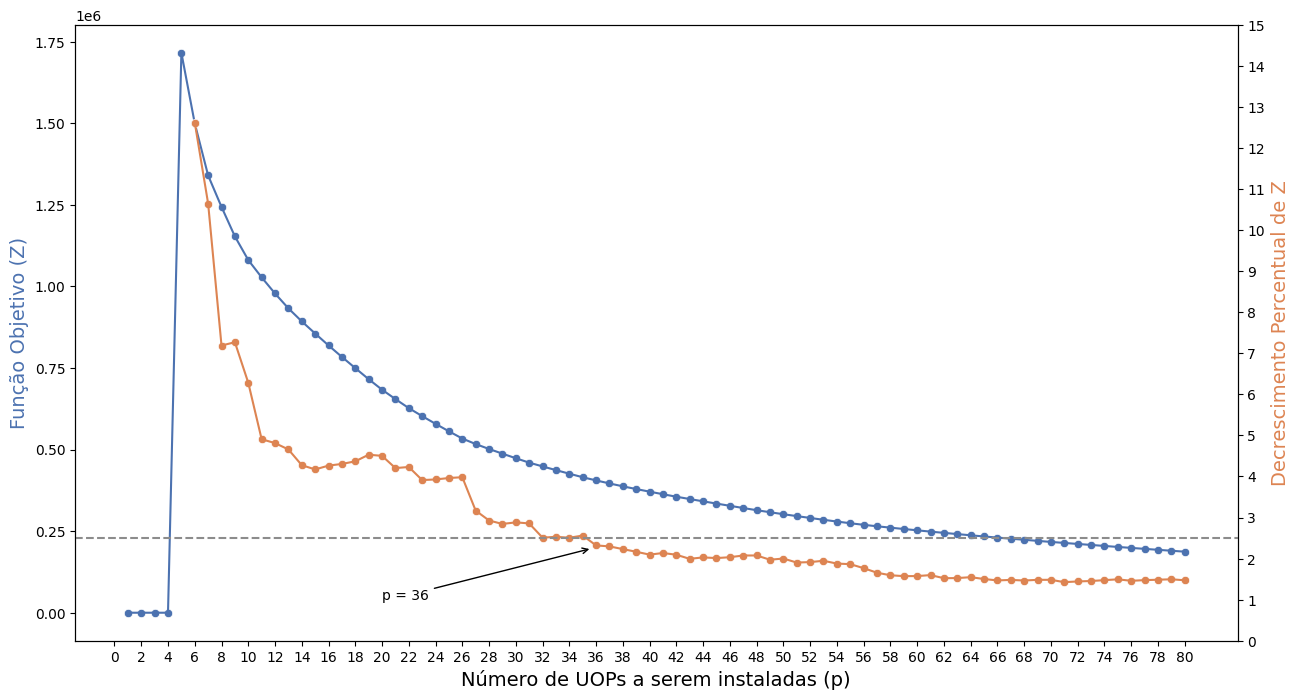

In [18]:
plot_fo(df_results_q0, "p")

In [19]:
df_results_q0

,name,p,q,solver,is_feasible,is_optimal,obj_function,obj_function_abs_diff,obj_function_abs_pct_change
0,model_p1_q0_results,1,0,gurobi,False,False,0.0000,0.0000,NaN
2,model_p2_q0_results,2,0,gurobi,False,False,0.0000,0.0000,NaN
5,model_p3_q0_results,3,0,gurobi,False,False,0.0000,0.0000,NaN
9,model_p4_q0_results,4,0,gurobi,False,False,0.0000,0.0000,NaN
14,model_p5_q0_results,5,0,gurobi,True,True,1715898.5487,1715898.5487,inf
20,model_p6_q0_results,6,0,gurobi,True,True,1499386.2742,216512.2746,12.6180
27,model_p7_q0_results,7,0,gurobi,True,True,1339785.9895,159600.2846,10.6444
35,model_p8_q0_results,8,0,gurobi,True,True,1243477.9222,96308.0673,7.1883
44,model_p9_q0_results,9,0,gurobi,True,True,1153093.5795,90384.3427,7.2687
54,model_p10_q0_results,10,0,gurobi,True,True,1080655.7591,72437.8204,6.2820


In [20]:
# Verifica a distribuição das UOPs por solução factível:

df_uops_by_sols = get_uops_by_sol(df_feasibles)
df_uops_by_sols.head()

,p,q,name
0,5,0,CAPITAO LEONIDAS MARQUES 01
1,5,0,CURITIBA 04
2,5,0,IMBITUVA 01
3,5,0,LONDRINA 03
4,5,0,MARINGA 01


In [21]:
df_uops_by_sols.shape

(102731, 3)

In [22]:
# Filtra só o range desejado:

p = 36
range_p = [p for p in range(p, 50+1)]
print(range_p)
print(len(range_p))
df_uops_by_sols_range = df_uops_by_sols[df_uops_by_sols['p'].isin(range_p)].copy()
df_uops_by_sols_range.head()

[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
15


,p,q,name
14223,36,0,APUCARANA 01
14224,36,0,ARAPONGAS 03
14225,36,0,UOP06-DEL01-PR
14226,36,0,CAMPINA GRANDE DO SUL 03
14227,36,0,CAMPINA GRANDE DO SUL 06


In [23]:
df_uops_all_range_q0 = agg_and_merge_uops(df_uops_base, df_uops_by_sols_range, len(range_p), q=0)

In [24]:
df_uops_all_range_q0.head()

,name,municipality,is_uop,n_accidents,microregion,mesoregion,immediate_region,mun_name_orig,n,pct_solutions,UOP,Município,Atual,Soluções
0,IRATI 02,IRATI,False,168.0000,IRATI,SUDESTE PARANAENSE,IRATI,Irati,15.0000,100.0000,IRATI 02,Irati,Não,15 (100%)
1,SAO JOSE DOS PINHAIS 03,SAO JOSE DOS PINHAIS,False,1024.0000,CURITIBA,METROPOLITANA DE CURITIBA,CURITIBA,São José dos Pinhais,15.0000,100.0000,SAO JOSE DOS PINHAIS 03,São José dos Pinhais,Não,15 (100%)
2,SANTO ANTONIO DO SUDOESTE 02,SANTO ANTONIO DO SUDOESTE,False,78.0000,FRANCISCO BELTRAO,SUDOESTE PARANAENSE,FRANCISCO BELTRAO,Santo Antônio do Sudoeste,15.0000,100.0000,SANTO ANTONIO DO SUDOESTE 02,Santo Antônio do Sudoeste,Não,15 (100%)
3,UOP05-DEL01-PR,PARANAGUA,True,463.0000,PARANAGUA,METROPOLITANA DE CURITIBA,PARANAGUA,Paranaguá,15.0000,100.0000,UOP05-DEL01-PR,Paranaguá,Sim,15 (100%)
4,IBAITI 01,IBAITI,False,60.0000,IBAITI,NORTE PIONEIRO PARANAENSE,IBAITI,Ibaiti,15.0000,100.0000,IBAITI 01,Ibaiti,Não,15 (100%)


In [25]:
df_uops_all_range_q0.shape

(419, 14)

In [26]:
# Quadrantes não usados
df_0 = df_uops_all_range_q0[df_uops_all_range_q0['pct_solutions'] == 0].copy()
df_0.shape

(361, 14)

In [27]:
df_0[df_0['is_uop'] == True].shape

(26, 14)

In [28]:
df_0[df_0['is_uop'] == False].shape

(335, 14)

In [29]:
df_choosen = df_uops_all_range_q0[(df_uops_all_range_q0['pct_solutions'] > 0)]
df_choosen.shape

(58, 14)

In [30]:
df_choosen_100 = df_choosen[df_choosen['pct_solutions'] == 100].copy()

In [31]:
df_choosen_100_current = df_choosen_100[df_choosen_100['is_uop'] == True].copy()
df_choosen_100_current.shape

(4, 14)

In [32]:
df_choosen_100_current = df_choosen_100_current.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_current[''] = df_choosen_100_current.index+1
print(df_choosen_100_current[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
  &            UOP &   Município \\
\midrule
1 & UOP06-DEL01-PR &  Balsa Nova \\
2 & UOP05-DEL01-PR &   Paranaguá \\
3 & UOP02-DEL09-PR &   Paranavaí \\
4 & UOP01-DEL02-PR & Pato Branco \\
\bottomrule
\end{tabular}



/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_62400/1496208111.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_100_current[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [33]:
df_choosen_100_candidate = df_choosen_100[df_choosen_100['is_uop'] == False].copy()
df_choosen_100_candidate.shape

(25, 14)

In [34]:
df_choosen_100_candidate = df_choosen_100_candidate.sort_values(by=['Município', 'UOP']).reset_index(drop=True)
df_choosen_100_candidate[''] = df_choosen_100_candidate.index+1
print(df_choosen_100_candidate[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))

\begin{tabular}{rll}
\toprule
   &                          UOP &                 Município \\
\midrule
 1 &                 APUCARANA 01 &                 Apucarana \\
 2 &                 ARAPONGAS 03 &                 Arapongas \\
 3 &     CAMPINA GRANDE DO SUL 03 &     Campina Grande do Sul \\
 4 &     CAMPINA GRANDE DO SUL 06 &     Campina Grande do Sul \\
 5 &               CAMPO LARGO 04 &               Campo Largo \\
 6 &  CAPITAO LEONIDAS MARQUES 01 &  Capitão Leônidas Marques \\
 7 &                  CASCAVEL 04 &                  Cascavel \\
 8 &         CORNELIO PROCOPIO 02 &         Cornélio Procópio \\
 9 &                  CURITIBA 01 &                  Curitiba \\
10 &                  CURITIBA 03 &                  Curitiba \\
11 &                  CURITIBA 06 &                  Curitiba \\
12 &             FOZ DO IGUACU 04 &             Foz do Iguaçu \\
13 &                    IBAITI 01 &                    Ibaiti \\
14 &                     IRATI 02 &                

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_62400/18753206.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_100_candidate[['', 'UOP', 'Município']].to_latex(index=False, multirow=True))


In [35]:
df_choosen_lt100 = df_choosen[df_choosen['pct_solutions'] < 100].copy()
df_choosen_lt100.shape

(29, 14)

In [36]:
df_choosen_lt100 = df_choosen_lt100.sort_values(by=['Atual', 'pct_solutions', 'Município', 'UOP'], ascending=[False, False, True, True]).reset_index(drop=True)
df_choosen_lt100[''] = df_choosen_lt100.index+1
print(df_choosen_lt100[['', 'UOP', 'Atual', 'Município', 'Soluções']].to_latex(index=False, multirow=True))

\begin{tabular}{rllll}
\toprule
   &                        UOP & Atual &               Município & Soluções \\
\midrule
 1 &             UOP04-DEL01-PR &   Sim &               Guaratuba & 12 (80\%) \\
 2 &             UOP02-DEL06-PR &   Sim & Marechal Cândido Rondon &  8 (53\%) \\
 3 &             UOP01-DEL04-PR &   Sim &                Cascavel &  2 (13\%) \\
 4 &             MANDIRITUBA 02 &   Não &             Mandirituba & 14 (93\%) \\
 5 &            CAMPO MOURAO 02 &   Não &            Campo Mourão & 13 (87\%) \\
 6 &                 UBIRATA 04 &   Não &                 Ubiratã & 13 (87\%) \\
 7 &              GUARAPUAVA 03 &   Não &              Guarapuava & 12 (80\%) \\
 8 &           PRUDENTOPOLIS 02 &   Não &           Prudentópolis & 12 (80\%) \\
 9 &                MORRETES 02 &   Não &                Morretes & 11 (73\%) \\
10 &                MARIALVA 01 &   Não &                Marialva & 10 (67\%) \\
11 &              GUARANIACU 01 &   Não &              Guaraniaçu &  

/var/folders/j1/pt3jwk353xqck3ls5h5twtn80000gn/T/ipykernel_62400/2961092546.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_choosen_lt100[['', 'UOP', 'Atual', 'Município', 'Soluções']].to_latex(index=False, multirow=True))


In [37]:
# Considerando a solução p = 36 e q = 0...

df_plot = df_uops_by_sols_range[(df_uops_by_sols_range['p'].isin(range_p)) & (df_uops_by_sols_range['q'] == 0)].copy()
df_plot = df_plot[df_plot['name'].isin(df_choosen_lt100['name'])].copy()
df_plot.head()


,p,q,name
14229,36,0,CANTAGALO 01
14236,36,0,FAROL 02
14238,36,0,GUARANIACU 01
14239,36,0,GUARAPUAVA 08
14240,36,0,UOP04-DEL01-PR


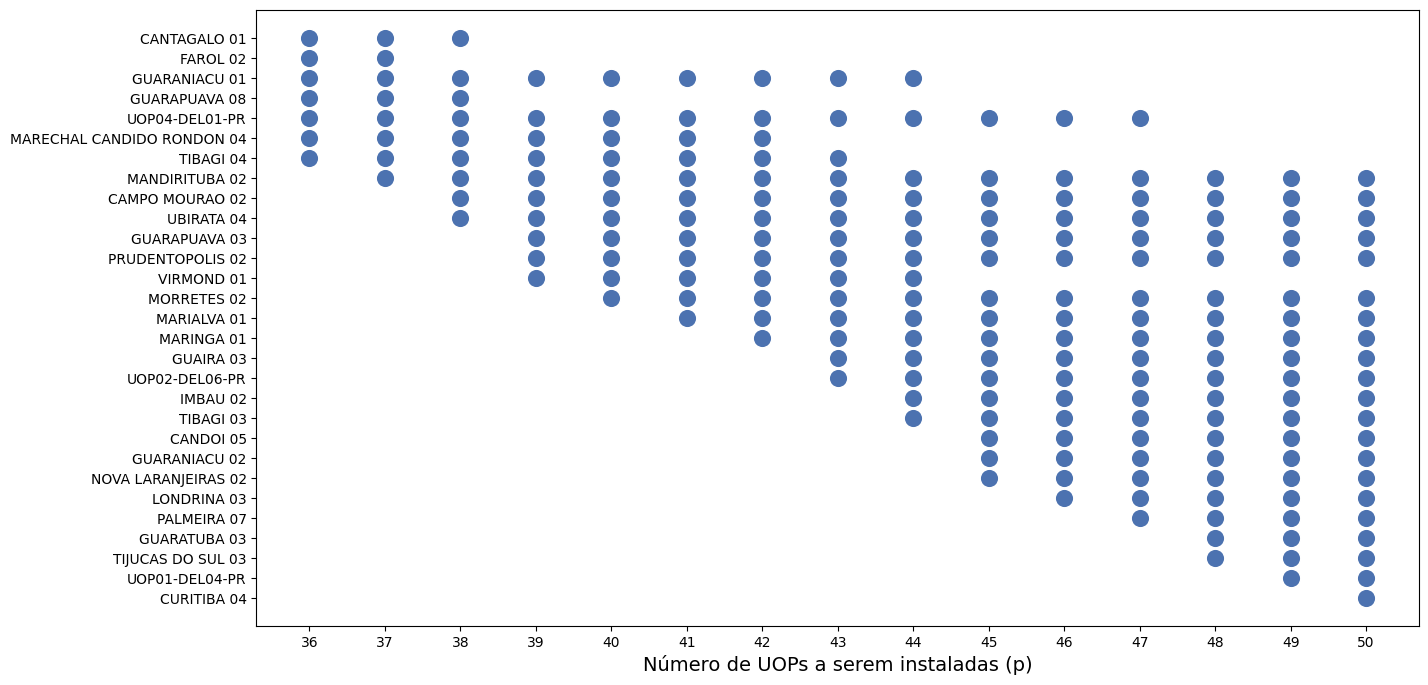

In [38]:
plot_uops_by_sol(df_plot, range_p)

In [39]:
uop_alocada = "UOP02-DEL06-PR"
uop_proposta = "MARECHAL CANDIDO RONDON 04"
q = 0
p = 43
df_sol_43 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-07-10 11:00:25.586 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 348355.5429196706
2023-07-10 11:00:25.586 | INFO     | __main__:get_realoc_solution:196 - FO final: 350120.5369462591
2023-07-10 11:00:25.587 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 1764.9940265885089 | 0.51%
2023-07-10 11:00:25.587 | INFO     | __main__:get_realoc_solution:198 - Distância entre UOP02-DEL06-PR e MARECHAL CANDIDO RONDON 04: 11.12km


In [40]:
uop_alocada = "TIBAGI 03"
uop_proposta = "TIBAGI 04"
q = 0
p = 44
df_sol_44 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=1764.9940265885089)

2023-07-10 11:00:28.988 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 343050.75917869655
2023-07-10 11:00:28.989 | INFO     | __main__:get_realoc_solution:196 - FO final: 346235.9714550707
2023-07-10 11:00:28.989 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 3185.2122763741645 | 0.93%
2023-07-10 11:00:28.989 | INFO     | __main__:get_realoc_solution:198 - Distância entre TIBAGI 03 e TIBAGI 04: 15.02km


In [41]:
uop_alocada = "GUARANIACU 02"
uop_proposta = "GUARANIACU 01"
q = 0
p = 45
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=3185.2122763741645)

2023-07-10 11:00:30.341 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 337604.4531835417
2023-07-10 11:00:30.341 | INFO     | __main__:get_realoc_solution:196 - FO final: 341364.9458606557
2023-07-10 11:00:30.341 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 3760.4926771139726 | 1.11%
2023-07-10 11:00:30.342 | INFO     | __main__:get_realoc_solution:198 - Distância entre GUARANIACU 02 e GUARANIACU 01: 23.0km


In [42]:
uop_alocada = "CANDOI 05"
uop_proposta = "VIRMOND 01"
q = 0
p = 45
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta, last_fo_dif=3760.4926771139726)

2023-07-10 11:00:33.204 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 338179.7335842815
2023-07-10 11:00:33.204 | INFO     | __main__:get_realoc_solution:196 - FO final: 340493.5047226882
2023-07-10 11:00:33.205 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 2313.7711384066497 | 0.68%
2023-07-10 11:00:33.205 | INFO     | __main__:get_realoc_solution:198 - Distância entre CANDOI 05 e VIRMOND 01: 22.95km


In [43]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 48
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-07-10 11:00:34.338 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 314159.98963128845
2023-07-10 11:00:34.339 | INFO     | __main__:get_realoc_solution:196 - FO final: 315113.2269278284
2023-07-10 11:00:34.339 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 953.2372965399409 | 0.3%
2023-07-10 11:00:34.339 | INFO     | __main__:get_realoc_solution:198 - Distância entre GUARATUBA 03 e UOP04-DEL01-PR: 10.0km


In [44]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 49
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-07-10 11:00:38.309 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 307963.86072083673
2023-07-10 11:00:38.309 | INFO     | __main__:get_realoc_solution:196 - FO final: 308917.0980173767
2023-07-10 11:00:38.310 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 953.2372965399409 | 0.31%
2023-07-10 11:00:38.310 | INFO     | __main__:get_realoc_solution:198 - Distância entre GUARATUBA 03 e UOP04-DEL01-PR: 10.0km


In [45]:
uop_alocada = "GUARATUBA 03"
uop_proposta = "UOP04-DEL01-PR"
q = 0
p = 50
df_sol_45 = get_realoc_solution(q, p, uop_alocada, uop_proposta)

2023-07-10 11:00:40.890 | INFO     | __main__:get_realoc_solution:195 - FO inicial: 301801.57001879066
2023-07-10 11:00:40.890 | INFO     | __main__:get_realoc_solution:196 - FO final: 302754.8073153306
2023-07-10 11:00:40.891 | INFO     | __main__:get_realoc_solution:197 - Variação da FO: 953.2372965399409 | 0.32%
2023-07-10 11:00:40.891 | INFO     | __main__:get_realoc_solution:198 - Distância entre GUARATUBA 03 e UOP04-DEL01-PR: 10.0km


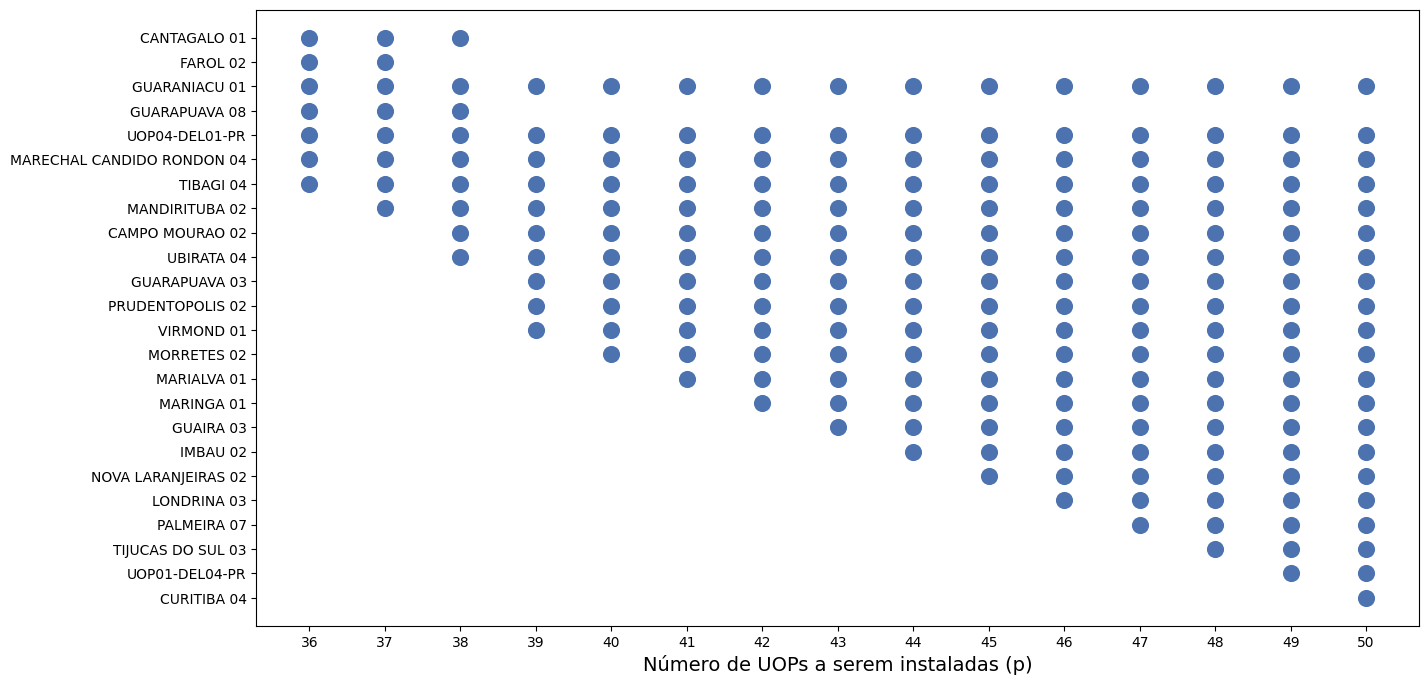

In [46]:
realoc = {
    "UOP02-DEL06-PR":"MARECHAL CANDIDO RONDON 04",
    "TIBAGI 03": "TIBAGI 04",
    "GUARANIACU 02": "GUARANIACU 01",
    "CANDOI 05": "VIRMOND 01",
    "GUARATUBA 03": "UOP04-DEL01-PR"
}

df_plot2 = df_plot[df_plot['p'].isin(range_p)]

df_plot2['name'] = np.where(
    df_plot2['name'].isin(realoc.keys()),
    df_plot2['name'].map(realoc),
    df_plot2['name']
)

plot_uops_by_sol(df_plot2, range_p)

In [ ]:
df_sol_q0_p39 = get_solution_details(q=0, p=39)

df_sol = df_sol_q0_p39.copy()
df_accidents = df_sol.dropna()
df_accidents['Quadrante'] = "Acidente"
df_uops = df_sol[df_sol['is_median'] == True].copy()
df_uops['Quadrante'] = "UOP"
cols = ["name", "municipality", "n_accidents", "latitude", "longitude", "median_lat", "median_lon", "Quadrante"]
df = pd.concat([df_accidents[cols], df_uops[cols]], ignore_index=True)
df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14
size="Qtd. acidentes"
sizes=(30, 500)
legend_name=""

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, hue="Quadrante")
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

for row in df.itertuples():
    lat0 = row.latitude
    lat1 = row.median_lat
    lon0 = row.longitude
    lon1 = row.median_lon
    x = (lon0, lon1)
    y = (lat0, lat1)
    plt.plot(x, y, color=PALETTE[1], linewidth='0.8')

plt.savefig('foo.png')   
plt.show()

In [ ]:
df_sol_q0_p39 = get_solution_details(q=0, p=39)
df_sol = df_sol_q0_p39.copy()

df_uops = df_sol[df_sol['is_median'] == True].copy()

df = pd.concat([df_uops[cols]], ignore_index=True)
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14
size="Qtd. acidentes"
sizes=(30, 500)
legend_name=""

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, label="UOP modelo")
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

p = sns.scatterplot(data=df_stations, x=x, y=y, label="UOP atual")

plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)

plt.savefig('foo.png')   
plt.show()

In [ ]:
df_sol_q0_p39 = get_solution_details(q=0, p=39)
df_uops_model = df_sol_q0_p39[df_sol_q0_p39['is_median'] == True].copy()

df_accidents, dict_stations = load_data()
df_stations = preprocess_stations(dict_stations)
df_stations = df_stations[df_stations['type'] == 'UOP'].reset_index(drop=True)
df_stations

# current_uops = [[(row.latitude, row.longitude), row.uop] for row in df_stations.itertuples()]
# model_uops = [[(row.latitude, row.longitude), row.name] for row in df_uops_model.itertuples()]

dist_matrix = get_distance_matrix(
    lat_rows=df_uops_model['latitude'],
    lon_rows=df_uops_model['longitude'],
    lat_cols=df_stations['latitude'],
    lon_cols=df_stations['longitude'],)


lst_idx = []
lst_dist = []
idx_to_ignore = []
for i in range(0, len(dist_matrix)):
    row = dist_matrix[i]
    min_dist = 999999999999
    min_index = 999999999999
    for j in range(0, len(row)):
        if i != j: # and j not in idx_to_ignore:
            if row[j] < min_dist:
                min_dist = row[j]
                min_index = list(row).index(row[j])
    lst_idx.append(min_index)
    lst_dist.append(min_dist)
    idx_to_ignore.append(min_index)

In [ ]:
df_dists = pd.DataFrame({'idx_j': lst_idx, 'dist': lst_dist})
df_dists['uop_i'] = [df_uops_model.iloc[u]['name'] for u in df_dists.index]
df_dists['uop_j'] = [df_stations.iloc[u]['uop'] for u in df_dists['idx_j'] if u < 999999]
df_dists = df_dists.sort_values(by='dist').reset_index(drop=True)

In [ ]:
df_dists['cum_count'] = df_dists.groupby(['uop_j']).cumcount()+1
df_dists

In [ ]:
df_agg = df_dists.groupby('uop_j')['idx_j'].count().reset_index(name='n')
df_dists = df_dists.merge(df_agg, how='left', on='uop_j')